In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

################################
###### Configurations #########
##############################
seed = 999
USE_DETERMINISTIC = True
K_FOLD_INDEX = 0
oversampling = 0 # How many times are we gonna over sample

## Model Configurations
MODEL_NAME="T0_MobileNetV3S_CBAM_MFSA-Exp5-KF1.keras"
IMG_SIZE=(224,224,3)
MODEL_TYPE = 'S' ## Mobilenet V3 - 'S' : Small; 'L': Large - default 'S'
FUSION_TYPE = 'add' ## feature fusion [mobilenet output && CBAM output ] - 'average', 'add', 'None' : Concatenate - default 'average'
POOLER_PLACEMENT = None ## Mobilenet Pooler Placement respective to fusion - 'before', 'after', 'None' : Pooler unused - default 'after'
CBAM_ORDER = 'normal' ## Originally in CBAM channel attention precedes spatial attention - 'normal', 'inverted' - default 'normal'
### Apparently CBAM_ORDER do not have much effect on the output --- So no need to use inverted. [check output of Version 2 & 3]

## Training Configurations
BATCH_SIZE=32
EPOCHS = 300
ES_PATIENCE = 13 ## Patience Epoch for Early Stopping
ES_MONITOR = 'val_loss'
LR_REDUCTION_FACTOR = 0.8 ## for ReduceLROnPlateau Callback
LR_REDUCTION_PATIENCE = 3 ## Patience for LR Reduction
LR_REDUCTION_MONITOR = 'val_loss'

##### FineTuning Part
INIT_LR1 = 2e-4 ## Initial Learning Rate (AdamW) 
W_DECAY1 = 5e-2 ## Weight Decay
MIN_LR1 = 1e-6 ## Minimum Learning Rate for ReduceLROnPlateau Callback

USE_WARMUP = False
WARMUP_EPOCH = 10
WARMUP_INIT_LR = INIT_LR1 / WARMUP_EPOCH
WARMUP_MAX_LR = INIT_LR1
WARMUP_INCREMENT_RATE = 0.5
##### Base Model Freezing Part
INIT_LR2 = 2e-5 # Initial Learning Rate for optimizer (AdamW)
W_DECAY2 = 5e-5 ## Weight Decay for optimizer
MIN_LR2 = 1e-9 # Minimum Learning Rate for ReduceLROnPlateau


def seedEverything(seed, deterministic = False):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        tf.config.threading.set_inter_op_parallelism_threads(2)
        tf.config.threading.set_intra_op_parallelism_threads(2)


seedEverything(seed, USE_DETERMINISTIC)
tf.__version__

2025-06-11 13:29:28.271150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-11 13:29:28.271292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-11 13:29:28.409257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = K_FOLD_INDEX # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 1 out of 5 folds
-------------------------------------------------



In [8]:
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  675  637  618  613  637  605  644  609  5463 	Total: (10501, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  226  213  207  205  213  202  215  204  1822 	Total: (3507, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [9]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [11]:
if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [12]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 10501 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.
Found 3507 files belonging to 9 classes.


# Sample Images

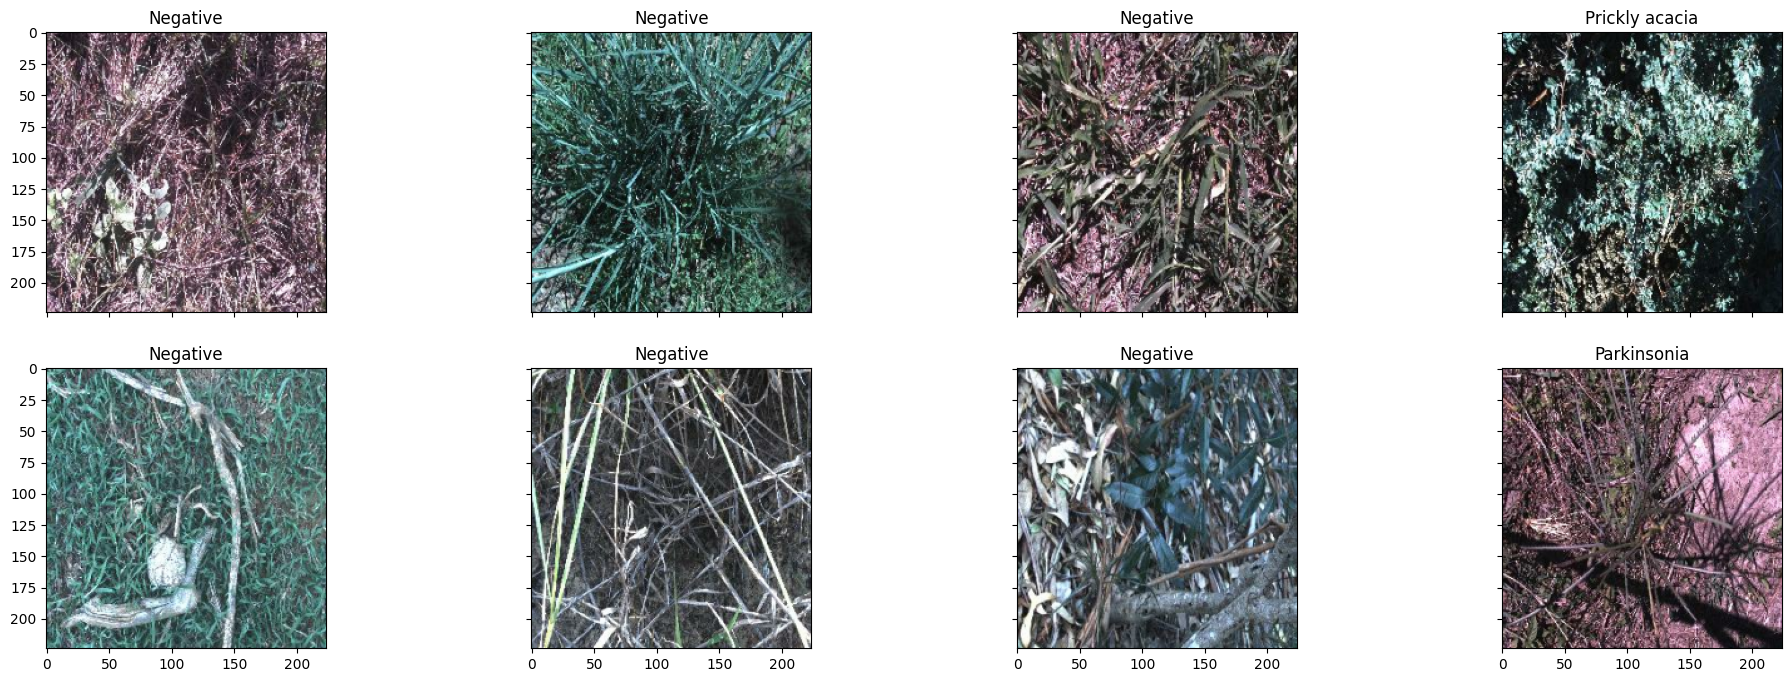

In [13]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [14]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class ChannelWiseMaxPool(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(ChannelWiseMaxPool,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x


class ChannelWiseAvgPool(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(ChannelWiseAvgPool,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        ## data_format parameter is of 2D Image, hence for 1D pool across channel have to reverse the data_format.
        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

class ChannelWiseConvolution(tf.keras.layers.Layer):
    def __init__(self, channel_conv_filters, channel_conv_kernel_size=16, channel_conv_strides=8, channel_conv_padding='same', channel_conv_activation=None, data_format='channels_last', **kwargs):
        super(ChannelWiseConvolution,self).__init__(**kwargs)
        
        ## data_format parameter is of 2D Image, hence for 1D pool across channel have to reverse the data_format.
        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.channel_conv = tf.keras.layers.Conv1D(filters = channel_conv_filters, kernel_size=channel_conv_kernel_size, strides=channel_conv_strides, padding=channel_conv_padding, activation=channel_conv_activation, use_bias=False, data_format=self.data_format)
      
    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1, input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.channel_conv(self.reshape_forward(x))
        x = self.reshape_backward(x)
        return x


def GlobalAverageOfMaximums(x, max_pool_size=2, layer_num=1, keep_out_dims=False):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num), keepdims=keep_out_dims)(_max)
    return _avg

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8, seed=42, layer_num=0):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer=keras.initializers.HeUniform(seed),
                             use_bias=True,
                             bias_initializer=keras.initializers.GlorotUniform(seed),
                           name=f'Dense_Squeeze_CA_{layer_num}')
    shared_layer_two = Dense(channel,
                             kernel_initializer=keras.initializers.HeUniform(seed),
                             use_bias=True,
                             bias_initializer=keras.initializers.GlorotUniform(seed),
                           name=f'Dense_Excite_CA_{layer_num}')

    avg_pool = GlobalAveragePooling2D(keepdims=True)(input_feature)
    assert avg_pool.shape[1:] == (1,1,channel)

    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)

    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D(keepdims=True)(input_feature)
    assert max_pool.shape[1:] == (1,1,channel)

    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)

    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])



def spatial_attention(input_feature, seed=42):
    kernel_size = 5

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1

    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer=keras.initializers.HeUniform(seed),
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [16]:
import math
### MFSA
def MultiFilterSpatialAttention(input_feature, kernel_size=7, num_pooled_channel=4, seed=42, layer_num = 0):
    in_shape = input_feature.shape

    stride = in_shape[-1] // num_pooled_channel
    pool_size = (stride * 2)

    channel_avg = ChannelWiseAvgPool(pool_size, stride, padding='same', name='MFSA_SAP_L{}'.format(layer_num))(input_feature)
    channel_max = ChannelWiseMaxPool(pool_size, stride, padding='same' , name='MFSA_SMP_L{}'.format(layer_num))(input_feature)

    concat = layers.Concatenate(axis=3, name='MFSA_ConcatChannels_L{}'.format(layer_num))([channel_avg, channel_max])
    
    mfsa_out = layers.Conv2D(filters = in_shape[-1],
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer=keras.initializers.HeUniform(seed),
                    use_bias=False,
                    groups=num_pooled_channel,
                    name="MFSA_Conv_L{}".format(layer_num))(concat)

    mfsa_out =  layers.Multiply(name="MFSA_Multiply_L{}".format(layer_num))([input_feature, mfsa_out])
    
    return mfsa_out


def modified_cbam_block(cbam_feature, ratio=8, mfsa_kernel=7, mfsa_pool_size=4, seed=42, order='normal', layer_num=0):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    if order == 'inverted':
        cbam_feature = MultiFilterSpatialAttention(cbam_feature, kernel_size=mfsa_kernel, num_pooled_channel=mfsa_pool_size, seed=seed, layer_num=layer_num)
        cbam_feature = channel_attention(cbam_feature, ratio, layer_num=layer_num, seed=seed)
    else:
        cbam_feature = channel_attention(cbam_feature, ratio, layer_num=layer_num, seed=seed)
        cbam_feature = MultiFilterSpatialAttention(cbam_feature, kernel_size=mfsa_kernel, num_pooled_channel=mfsa_pool_size, seed=seed, layer_num=layer_num)
        
    return cbam_feature

# Building MobileNet Model

In [17]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model


def hard_sigmoid(x):
    relu6 = layers.ReLU(max_value=6)
    return relu6(x + 3) / 6
    
def hard_swish(x):
    return x * hard_sigmoid(x)

def MobilenetV3Base(img_size, use='S'): # use = S (small) or L (large)
    # Load the MobileNet model with weights pre-trained on ImageNet.
    if(use=='S'):
        mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet', include_preprocessing=False)
    if(use=='L'):
        mobilenet = MobileNetV3Large(input_shape=img_size, weights='imagenet', include_preprocessing=False)
        
    mobilenet.trainable = True

    base_index = 0
    for i in range(len(mobilenet.layers)):
        if('global_average_pooling2d' in mobilenet.layers[i].name):
            base_index = i
            break
            
    out_layer = mobilenet.layers[base_index-1]
    base_model =  keras.Model(inputs=mobilenet.layers[0].output, outputs=out_layer.output, name = mobilenet.name+"_base_")
    base_model.trainable = True
    
    pi0 = base_index+1 # pooler index start
    pi1 = base_index+1 # pooler index end
    for i in range(base_index, len(mobilenet.layers)):
        if('dropout' in mobilenet.layers[i].name):
            pi1 = i
            break
    
    pooler = keras.Model(inputs=mobilenet.layers[pi0].input, outputs=mobilenet.layers[pi1].output, name="MobileNet-Pooler")
    
    return base_model , pooler

def buildModel(IMG_SIZE, mtype = 'S', fusion_type='average', cbam_order='normal', skip_preprocess=False):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, pooler = MobilenetV3Base(IMG_SIZE, use=mtype)
    base_model.trainable = True
    pooler.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    if not skip_preprocess:
        x = layers.Rescaling(1./255, name='PP_Rescale_down')(inputs)
        x = layers.Resizing(IMG_SIZE[0], IMG_SIZE[1], name='PP_Resize')(x)
    
        x = augment(seed)(x)
    else:
        x = inputs
    
    x = base_model(x, training=True)
    x = layers.Dropout(0.2, seed=seed)(x) 
    
    ### Global Average of Maximums
    gavm_x = GlobalAverageOfMaximums(x, keep_out_dims=True, layer_num="_pre")

    x = modified_cbam_block(x, ratio=8, mfsa_kernel=7, mfsa_pool_size=16, order=cbam_order, seed=seed, layer_num=0)
    x = GlobalAverageOfMaximums(x, keep_out_dims=True, layer_num="_post")
    
    if fusion_type == 'average':
        x = layers.Average()([gavm_x, x])
    elif fusion_type == 'add':
        x = layers.Add()([gavm_x, x])
    else: 
        x = layers.Average()([gavm_x, x])
        
    x = layers.Dropout(0.2)(x)
    
    x = layers.Reshape((-1, 64))(x)
    x = layers.Dense(128, activation='relu', use_bias=False, kernel_initializer=keras.initializers.HeUniform(seed))(x)
    x = layers.Dense(256, activation='relu', use_bias=False, kernel_initializer=keras.initializers.HeUniform(seed))(x)
    x = layers.Dense(128, use_bias=False, kernel_regularizer='l1_l2')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(9, kernel_initializer=keras.initializers.HeUniform(seed), activation='softmax')(x)
    model_name = "DeepWeeds-" + base_model.name
    
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [18]:
model = buildModel(IMG_SIZE, mtype=MODEL_TYPE, fusion_type=FUSION_TYPE, cbam_order=CBAM_ORDER)
model.summary()

10734624/10734624 [==============================] - 1s 0us/step
Base Model: MobilenetV3small_base_
228
Model: "DeepWeeds-MobilenetV3small_base_"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 PP_Rescale_down (Rescaling  (None, 224, 224, 3)          0         ['input[0][0]']               
 )                                                                                                
                                                                                                  
 PP_Resize (Resizing)        (None, 224, 224, 3)          0         ['PP_Rescale_down[0][0]']     
                                                              

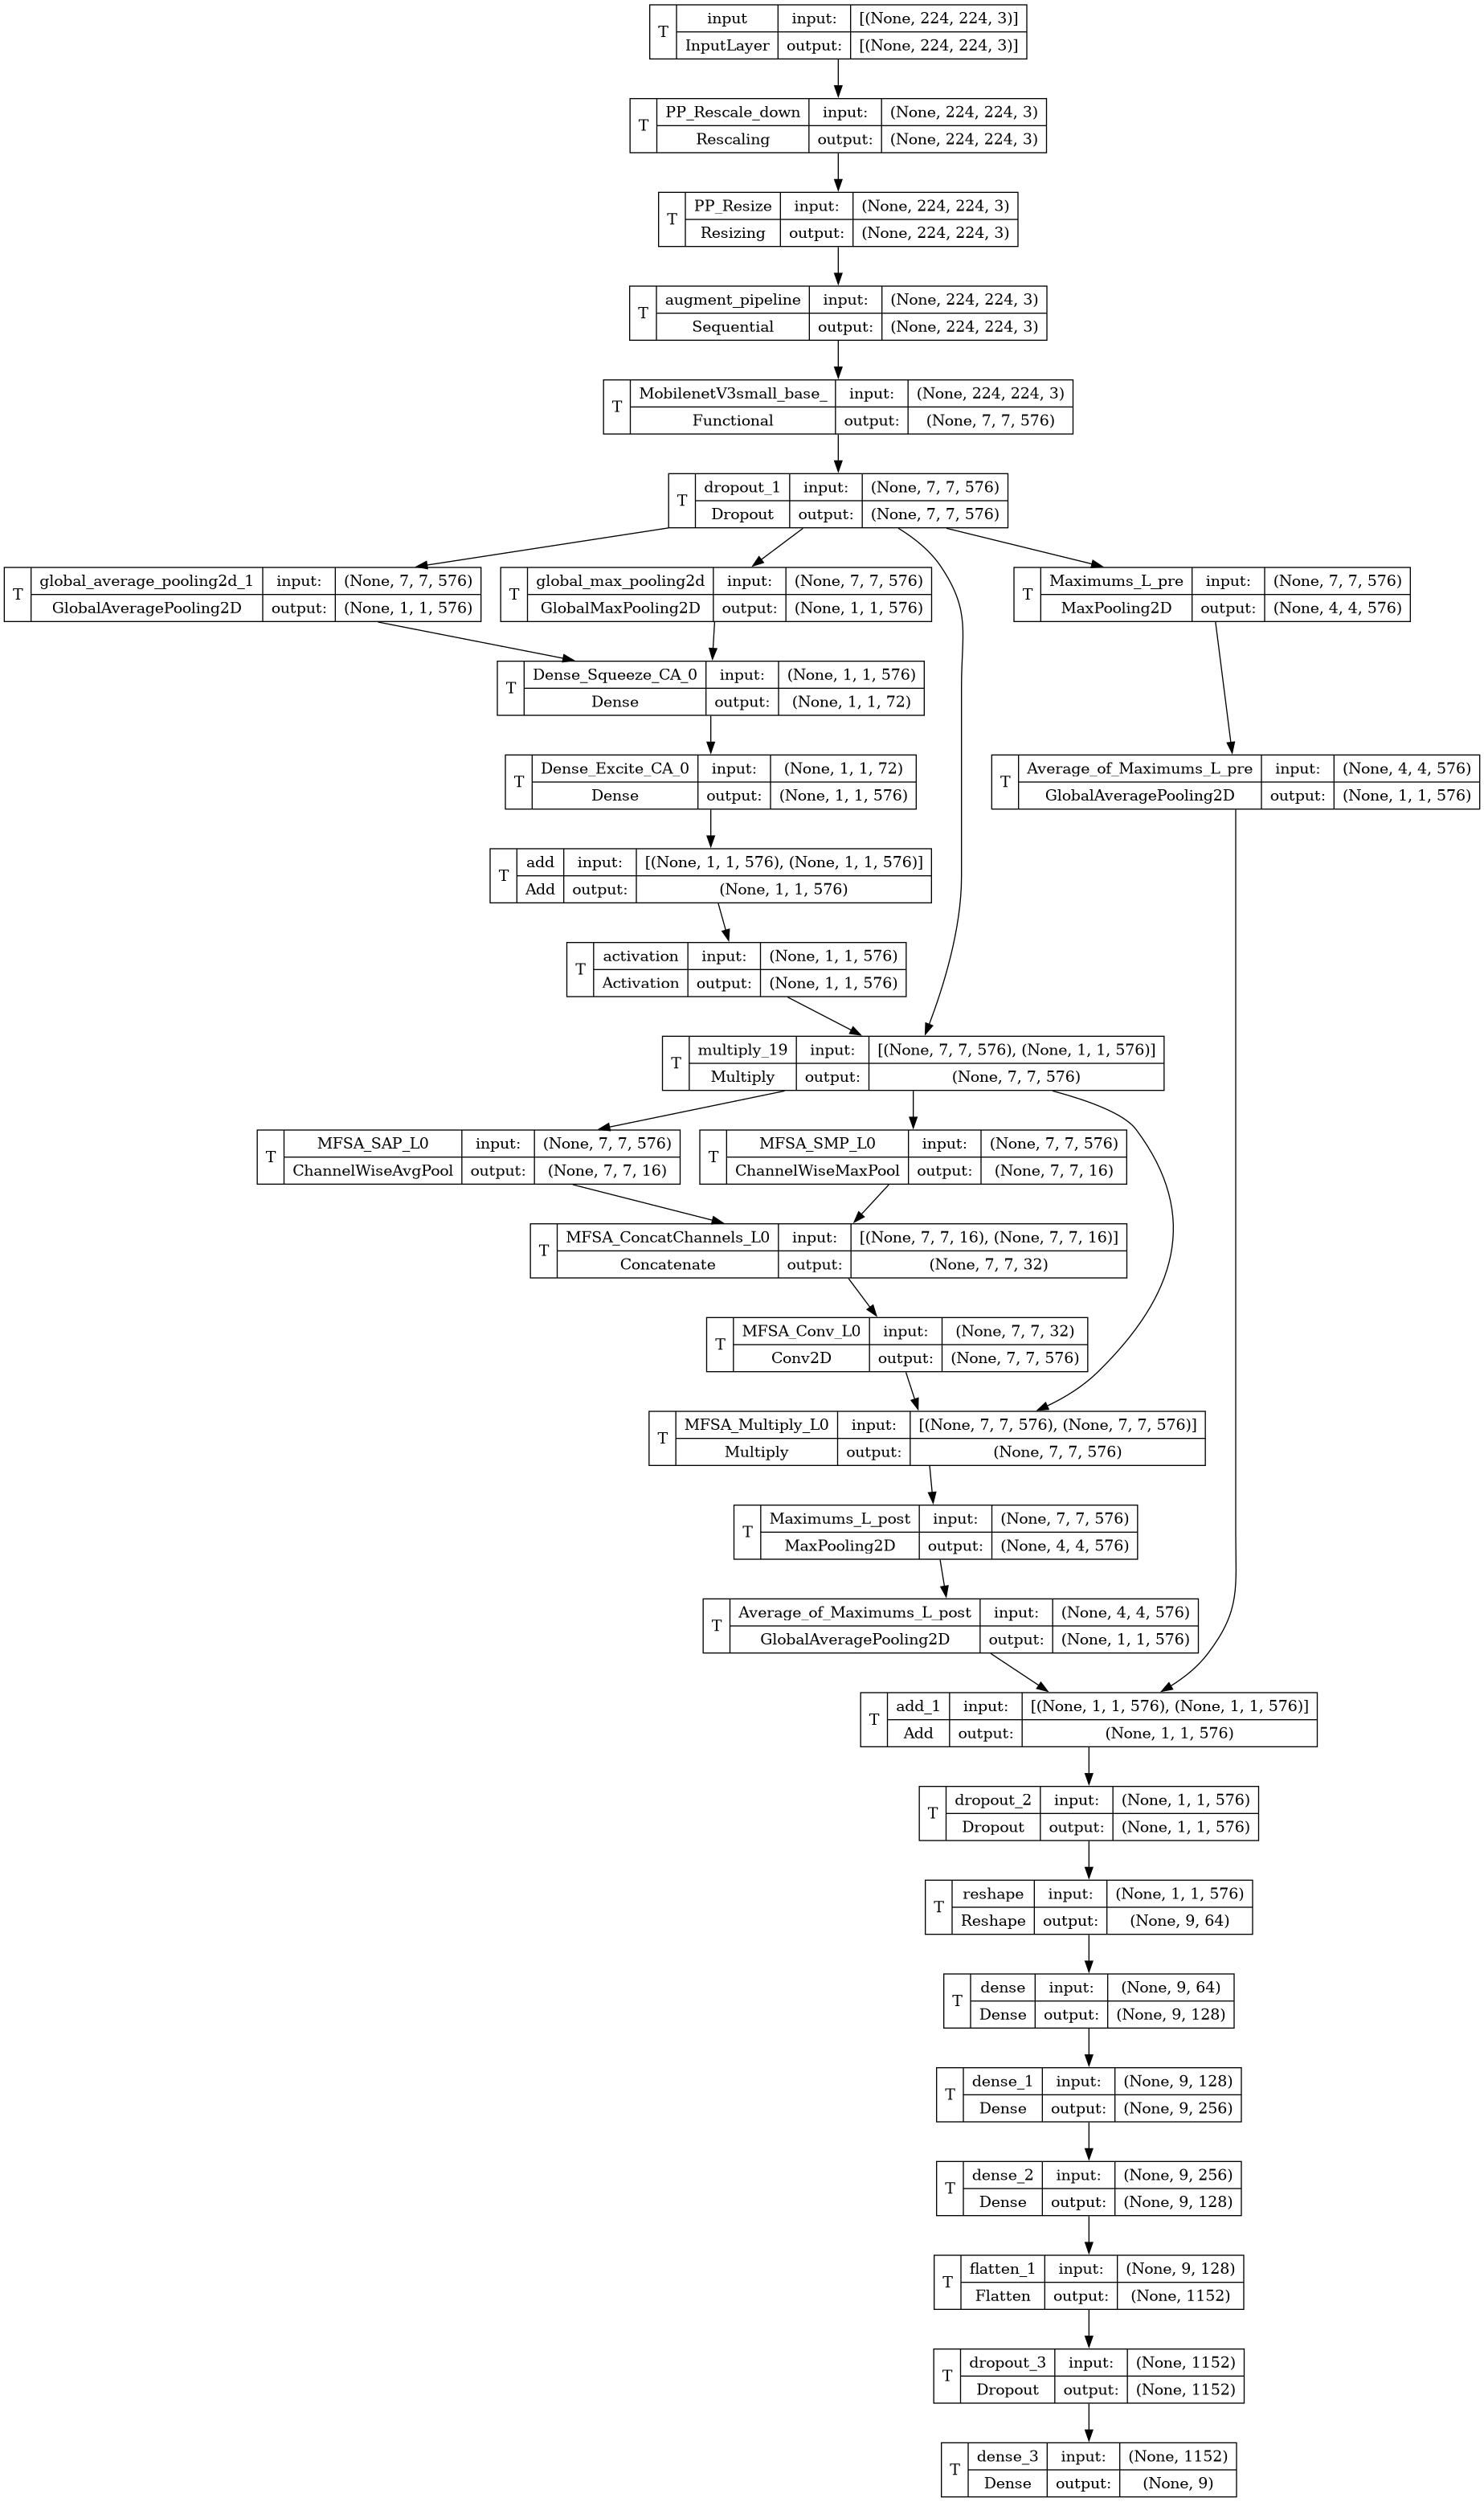

In [19]:
tf.keras.utils.plot_model(model, show_trainable=True, show_layer_names=True, show_shapes=True)

# Trial 1 - FineTuning

In [20]:
from tensorflow.keras.optimizers import RMSprop, AdamW

early_stopping = tf.keras.callbacks.EarlyStopping(monitor=ES_MONITOR, patience=ES_PATIENCE, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=LR_REDUCTION_MONITOR,factor=LR_REDUCTION_FACTOR, patience=LR_REDUCTION_PATIENCE, verbose=1, min_lr=MIN_LR1)

def scheduler(e, lr):
    if e < WARMUP_EPOCH:
        t = lr + (lr * WARMUP_INCREMENT_RATE)
        return t if t < WARMUP_MAX_LR else WARMUP_MAX_LR
    else:
        return lr
    
warmup = keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [early_stopping, reduce_lr] + ([warmup] if USE_WARMUP else [])

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=WARMUP_INIT_LR if USE_WARMUP else INIT_LR1,  weight_decay=W_DECAY1),
          metrics=['accuracy'])

model.optimizer.get_config()

{'name': 'AdamW',
 'weight_decay': 0.05,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 0.0002,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

Epoch 1/300


2025-06-11 13:36:22.465675: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1749648987.277938      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 55s 81ms/step - loss: 19.6945 - accuracy: 0.4672 - val_loss: 14.3144 - val_accuracy: 0.6290 - lr: 2.0000e-04
Epoch 2/300
329/329 [==============================] - 25s 76ms/step - loss: 10.6162 - accuracy: 0.5849 - val_loss: 7.1312 - val_accuracy: 0.6801 - lr: 2.0000e-04
Epoch 3/300
329/329 [==============================] - 25s 75ms/step - loss: 5.2386 - accuracy: 0.6378 - val_loss: 3.4863 - val_accuracy: 0.7358 - lr: 2.0000e-04
Epoch 4/300
329/329 [==============================] - 25s 76ms/step - loss: 2.7376 - accuracy: 0.6836 - val_loss: 1.9241 - val_accuracy: 0.7706 - lr: 2.0000e-04
Epoch 5/300
329/329 [==============================] - 25s 76ms/step - loss: 1.7302 - accuracy: 0.7136 - val_loss: 1.3209 - val_accuracy: 0.7792 - lr: 2.0000e-04
Epoch 6/300
329/329 [==============================] - 25s 75ms/step - loss: 1.2702 - accuracy: 0.7409 - val_loss: 0.9863 - val_accuracy: 0.8078 - lr: 2.0000e-04
Epoch 7/300
329/329 [================

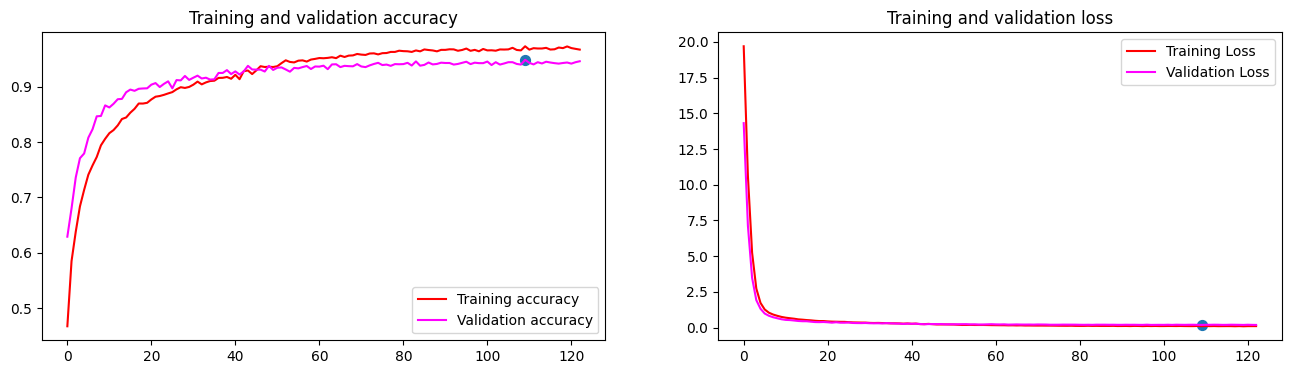

CPU times: user 1h 32min 28s, sys: 5min 2s, total: 1h 37min 31s
Wall time: 51min 53s


In [21]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr, warmup],
    )

print("Saving the Model")
model.save(MODEL_NAME)

# Plot training results
plot_loss_acc(history1.history)

# Evaluation#1

Train Set Statistics
model.evaluate
329/329 [==============================] - 8s 24ms/step - loss: 0.0541 - accuracy: 0.9869
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.97054   0.97630   0.97341       675
       Lantana    0.99048   0.97959   0.98500       637
   Parkinsonia    0.98086   0.99515   0.98795       618
    Parthenium    0.97585   0.98858   0.98217       613
Prickly acacia    0.99042   0.97331   0.98179       637
   Rubber vine    0.99013   0.99504   0.99258       605
     Siam weed    1.00000   0.98602   0.99296       644
    Snake weed    0.98342   0.97373   0.97855       609
      Negative    0.99105   0.99268   0.99186      5463

      accuracy                        0.98819     10501
     macro avg    0.98586   0.98449   0.98514     10501
  weighted avg    0.98822   0.98819   0.98819     10501


                False Positive Rate  Accuracy
Chinee apple               0.002035  0.976296
Lantana                    0.000608  0.979592
Parkinsonia                0.001214  0.995146
Parthenium                 0.001517  0.988581
Prickly acacia    

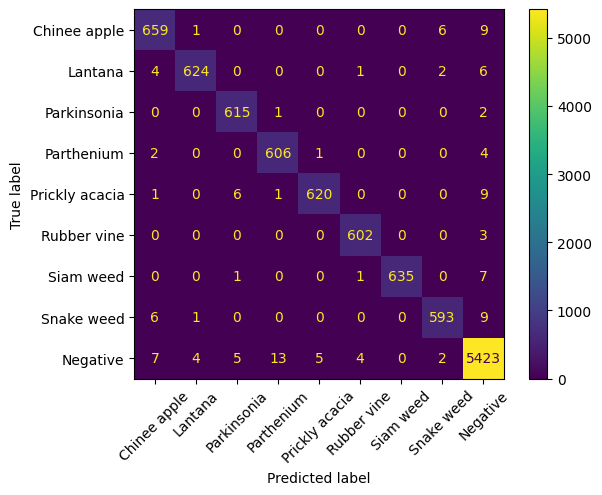


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 23ms/step - loss: 0.1984 - accuracy: 0.9369
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.85153   0.86667   0.85903       225
       Lantana    0.94146   0.90610   0.92344       213
   Parkinsonia    0.94258   0.95631   0.94940       206
    Parthenium    0.93532   0.92157   0.92840       204
Prickly acacia    0.94712   0.92925   0.93810       212
   Rubber vine    0.95980   0.94554   0.95262       202
     Siam weed    0.95455   0.87907   0.91525       215
    Snake weed    0.90000   0.84236   0.87023       203
      Negative    0.95113   0.97254   0.96172      1821

      accuracy                        0.94030      3501
     macro avg    0.93150   0.91327   0.92202      3501
  weighted avg    0.94022   0.94030   0.94001      3501


                False Positive Rate  Accuracy
Chinee apple               0.010379  0.866667
Lantana                    0.003650  0.906103
Parkinsonia                0.003642  0.956311
Parthenium                 0.003943  0.921569
Prickly acacia    

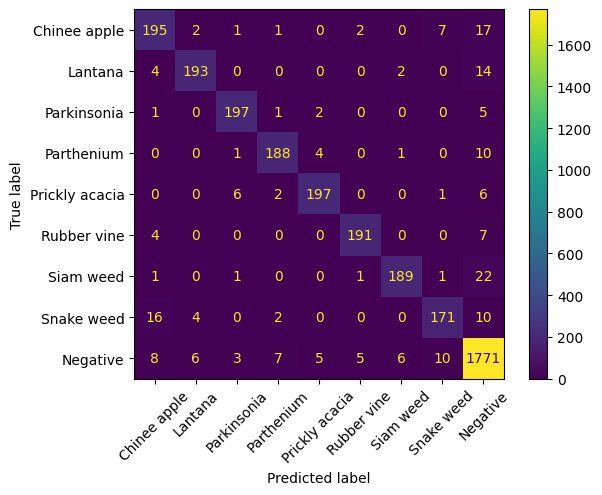


Testn Set Statistics
model.evaluate
110/110 [==============================] - 3s 25ms/step - loss: 4.2904 - accuracy: 0.4528
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.11377   0.08407   0.09669       226
       Lantana    0.09574   0.04225   0.05863       213
   Parkinsonia    0.36170   0.08213   0.13386       207
    Parthenium    0.14286   0.06341   0.08784       205
Prickly acacia    0.20833   0.04695   0.07663       213
   Rubber vine    0.12844   0.06931   0.09003       202
     Siam weed    0.17757   0.08837   0.11801       215
    Snake weed    0.11364   0.04902   0.06849       204
      Negative    0.53592   0.81065   0.64526      1822

      accuracy                        0.45281      3507
     macro avg    0.20866   0.14846   0.15283      3507
  weighted avg    0.35882   0.45281   0.37912      3507


                False Positive Rate  Accuracy
Chinee apple               0.045108  0.084071
Lantana                    0.025804  0.042254
Parkinsonia                0.009091  0.082126
Parthenium                 0.023622  0.063415
Prickly acacia    

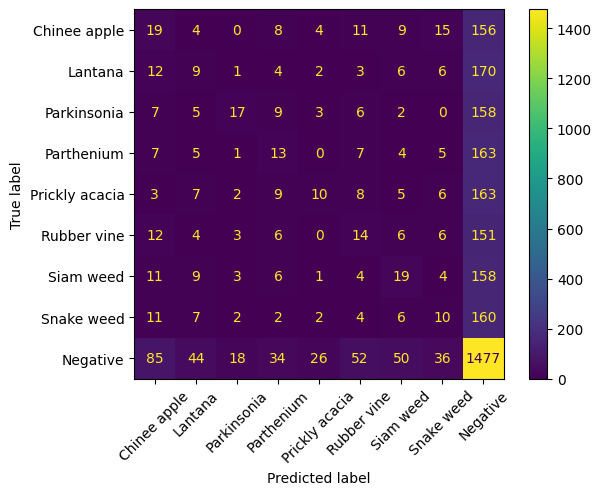

In [22]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)
print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)
print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

# Trial 2 - Freezing Base Model

In [23]:
for layer in model.layers:
    if 'base' in layer.name.lower():
        print("Freezing Layer", layer.name)
        layer.trainable = False

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=INIT_LR2,  weight_decay=W_DECAY2),
          metrics=['accuracy'])

model.optimizer.get_config()

Freezing Layer MobilenetV3small_base_


{'name': 'AdamW',
 'weight_decay': 5e-05,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 2e-05,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}


Validation Set Statistics
model.evaluate
110/110 [==============================] - 5s 23ms/step - loss: 0.1684 - accuracy: 0.9560
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.91589   0.87111   0.89294       225
       Lantana    0.96552   0.92019   0.94231       213
   Parkinsonia    0.95261   0.97573   0.96403       206
    Parthenium    0.93689   0.94608   0.94146       204
Prickly acacia    0.95673   0.93868   0.94762       212
   Rubber vine    0.97512   0.97030   0.97270       202
     Siam weed    0.96618   0.93023   0.94787       215
    Snake weed    0.90863   0.88177   0.89500       203
      Negative    0.96386   0.98133   0.97252      1821

      accuracy                        0.95601      3501
     macro avg    0.94905   0.93505   0.94183      3501
  weighted avg    0.95580   0.95601   0.95575      3501


                False Positive Rate  Accuracy
Chinee apple               0.005495  0.871111
Lantana                    0.002129  0.920188
Parkinsonia                0.003035  0.975728
Parthenium                 0.003943  0.946078
Prickly acacia    

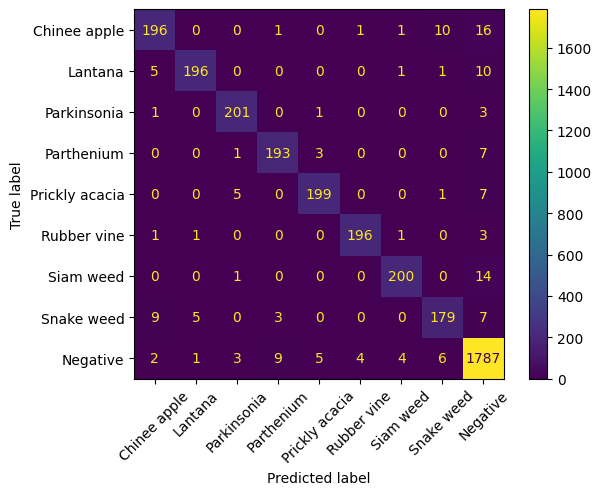

In [24]:
print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

model.evaluate
110/110 [==============================] - 3s 23ms/step - loss: 0.1415 - accuracy: 0.9575
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.90741   0.86726   0.88688       226
       Lantana    0.97561   0.93897   0.95694       213
   Parkinsonia    0.96714   0.99517   0.98095       207
    Parthenium    0.93750   0.95122   0.94431       205
Prickly acacia    0.94313   0.93427   0.93868       213
   Rubber vine    0.95477   0.94059   0.94763       202
     Siam weed    0.95775   0.94884   0.95327       215
    Snake weed    0.89806   0.90686   0.90244       204
      Negative    0.97113   0.97859   0.97485      1822

      accuracy                        0.95751      3507
     macro avg    0.94583   0.94020   0.94288      3507
  weighted avg    0.95738   0.95751   0.95737      3507


                False Positive Rate  Accuracy
Chinee apple               0.006096  0.867257
Lantana                    0.001518  0.938967
Parkinsonia                0.002121  0.995169
Parthenium                 0.003937  0.951220
Prickly acacia    

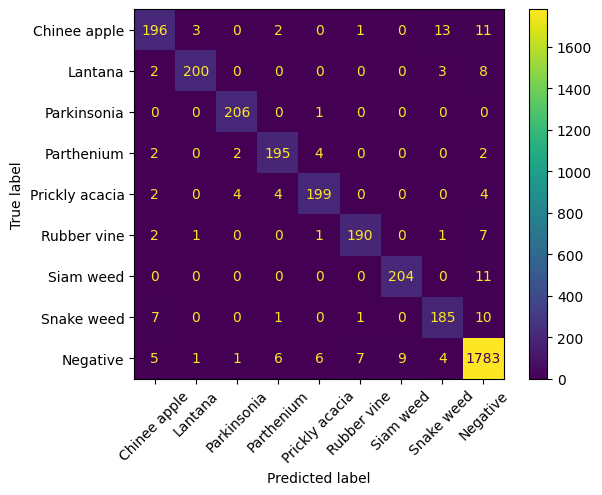

In [25]:
## Test After Freezing
a, b = eval_model(model, test_generator)

Epoch 1/300


2025-06-11 14:31:14.084830: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


329/329 [==============================] - 19s 41ms/step - loss: 0.2029 - accuracy: 0.9365 - val_loss: 0.1732 - val_accuracy: 0.9569 - lr: 2.0000e-05
Epoch 2/300
329/329 [==============================] - 14s 41ms/step - loss: 0.1918 - accuracy: 0.9395 - val_loss: 0.1785 - val_accuracy: 0.9566 - lr: 2.0000e-05
Epoch 3/300
329/329 [==============================] - 14s 42ms/step - loss: 0.1854 - accuracy: 0.9431 - val_loss: 0.1809 - val_accuracy: 0.9560 - lr: 2.0000e-05
Epoch 4/300
327/329 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.9427
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.5999999595806004e-05.
329/329 [==============================] - 14s 41ms/step - loss: 0.1800 - accuracy: 0.9427 - val_loss: 0.1854 - val_accuracy: 0.9557 - lr: 2.0000e-05
Epoch 5/300
329/329 [==============================] - 14s 42ms/step - loss: 0.1768 - accuracy: 0.9427 - val_loss: 0.1844 - val_accuracy: 0.9557 - lr: 1.6000e-05
Epoch 6/300
329/329 [===================

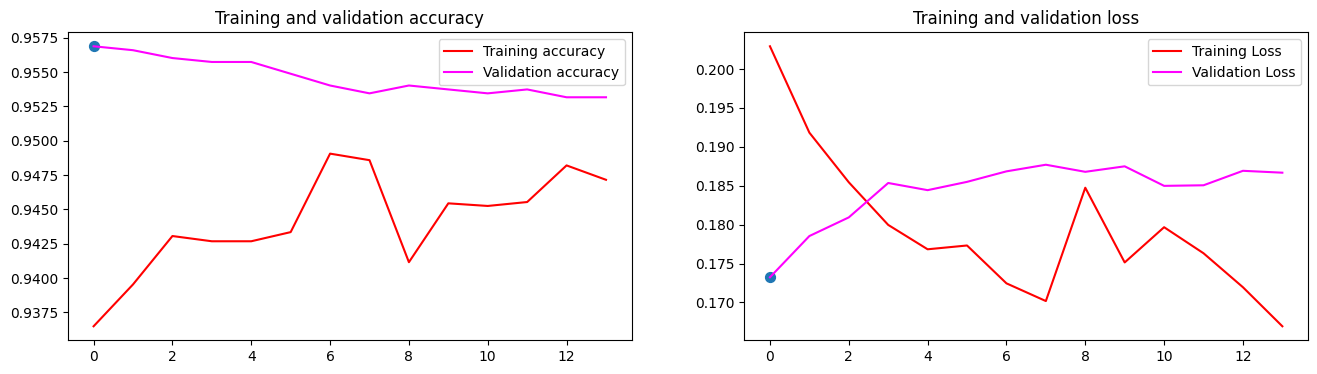

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=LR_REDUCTION_MONITOR,factor=LR_REDUCTION_FACTOR, patience=LR_REDUCTION_PATIENCE, verbose=LR_REDUCTION_PATIENCE, min_lr=MIN_LR2)

# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Model")
model.save(MODEL_NAME)

# Plot training results
plot_loss_acc(history2.history)

# Accuracy / Loss Plots

Total Epochs: range(0, 137)


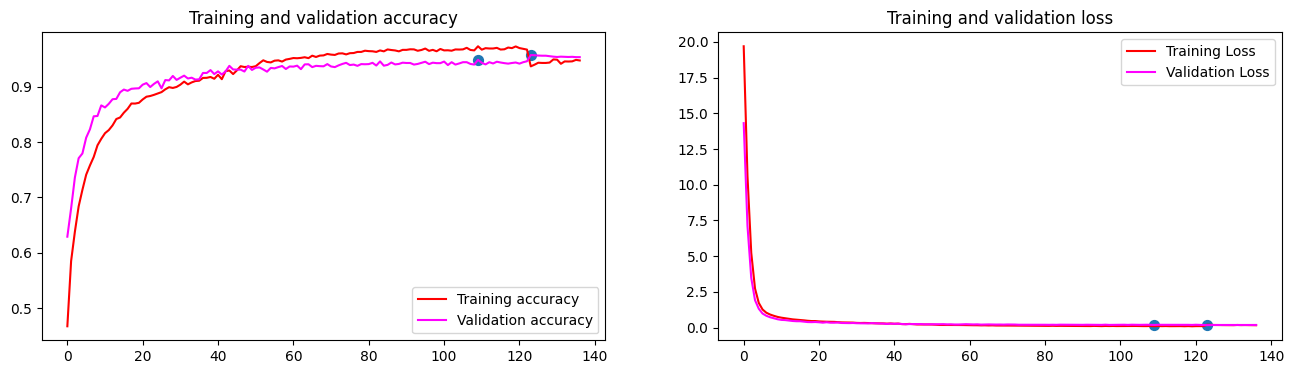

In [27]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es = ES_PATIENCE + 1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 123)


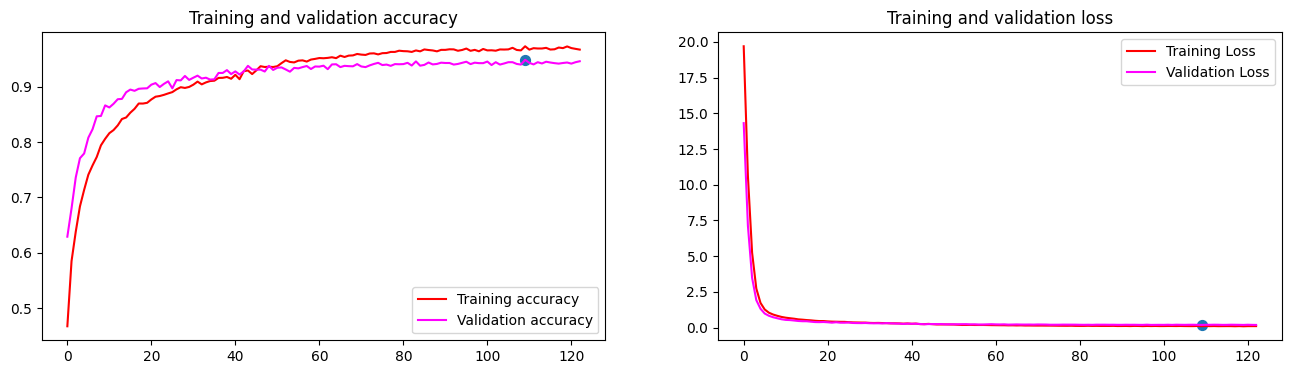

Total Epochs: range(0, 14)


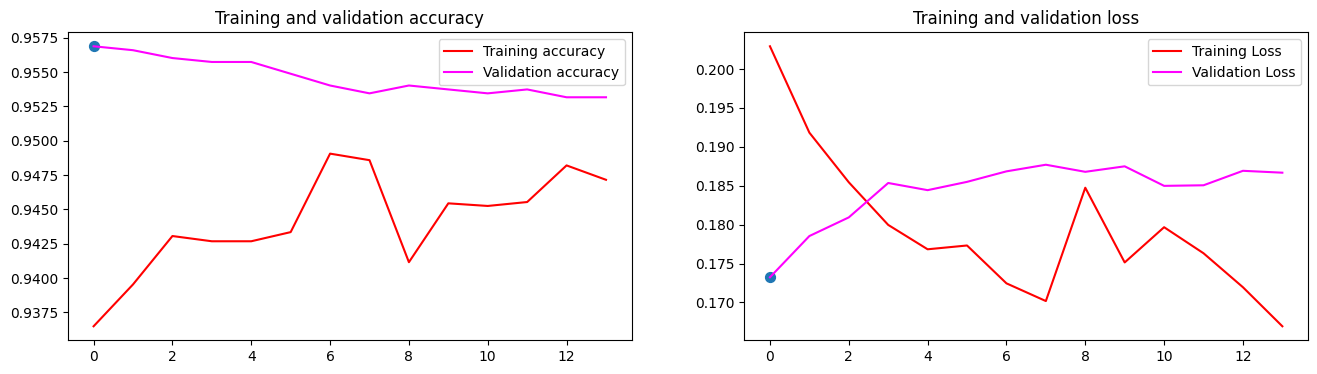

In [28]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluation#2

Train Set Statistics
model.evaluate
329/329 [==============================] - 8s 24ms/step - loss: 0.0353 - accuracy: 0.9944
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.98380   0.98963   0.98671       675
       Lantana    0.99842   0.99215   0.99528       637
   Parkinsonia    0.99838   1.00000   0.99919       618
    Parthenium    0.99513   1.00000   0.99756       613
Prickly acacia    0.98295   0.99529   0.98908       637
   Rubber vine    0.98695   1.00000   0.99343       605
     Siam weed    0.98620   0.99845   0.99228       644
    Snake weed    0.98852   0.99015   0.98934       609
      Negative    0.99853   0.99323   0.99587      5463

      accuracy                        0.99438     10501
     macro avg    0.99099   0.99543   0.99319     10501
  weighted avg    0.99442   0.99438   0.99439     10501


                False Positive Rate  Accuracy
Chinee apple               0.001119  0.989630
Lantana                    0.000101  0.992151
Parkinsonia                0.000101  1.000000
Parthenium                 0.000303  1.000000
Prickly acacia    

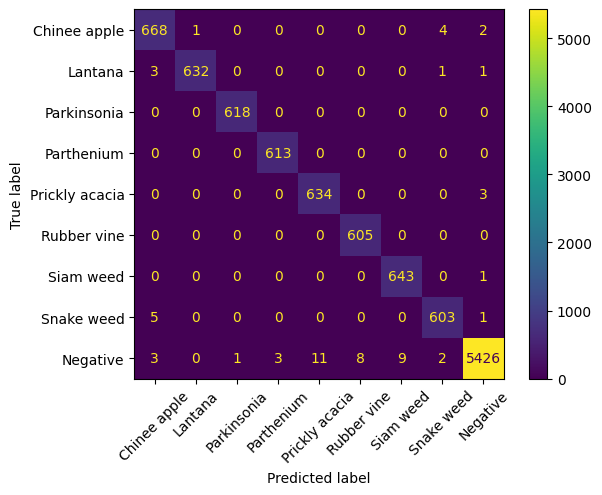


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 27ms/step - loss: 0.1732 - accuracy: 0.9569
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.93269   0.86222   0.89607       225
       Lantana    0.95215   0.93427   0.94313       213
   Parkinsonia    0.95238   0.97087   0.96154       206
    Parthenium    0.95545   0.94608   0.95074       204
Prickly acacia    0.95238   0.94340   0.94787       212
   Rubber vine    0.95215   0.98515   0.96837       202
     Siam weed    0.92035   0.96744   0.94331       215
    Snake weed    0.91878   0.89163   0.90500       203
      Negative    0.97049   0.97529   0.97288      1821

      accuracy                        0.95687      3501
     macro avg    0.94520   0.94182   0.94321      3501
  weighted avg    0.95677   0.95687   0.95665      3501


                False Positive Rate  Accuracy
Chinee apple               0.004274  0.862222
Lantana                    0.003041  0.934272
Parkinsonia                0.003035  0.970874
Parthenium                 0.002730  0.946078
Prickly acacia    

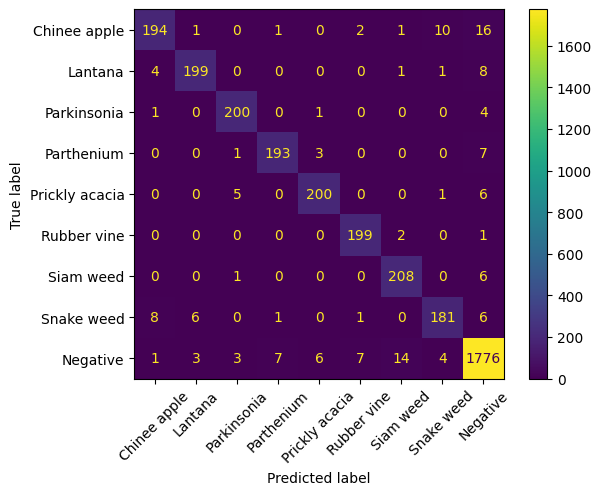


Testn Set Statistics
model.evaluate
110/110 [==============================] - 3s 23ms/step - loss: 0.1522 - accuracy: 0.9564
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.93301   0.86283   0.89655       226
       Lantana    0.96635   0.94366   0.95487       213
   Parkinsonia    0.97156   0.99034   0.98086       207
    Parthenium    0.94203   0.95122   0.94660       205
Prickly acacia    0.92237   0.94836   0.93519       213
   Rubber vine    0.93659   0.95050   0.94349       202
     Siam weed    0.91342   0.98140   0.94619       215
    Snake weed    0.89474   0.91667   0.90557       204
      Negative    0.97677   0.96926   0.97300      1822

      accuracy                        0.95637      3507
     macro avg    0.93965   0.94603   0.94248      3507
  weighted avg    0.95671   0.95637   0.95633      3507


                False Positive Rate  Accuracy
Chinee apple               0.004267  0.862832
Lantana                    0.002125  0.943662
Parkinsonia                0.001818  0.990338
Parthenium                 0.003634  0.951220
Prickly acacia    

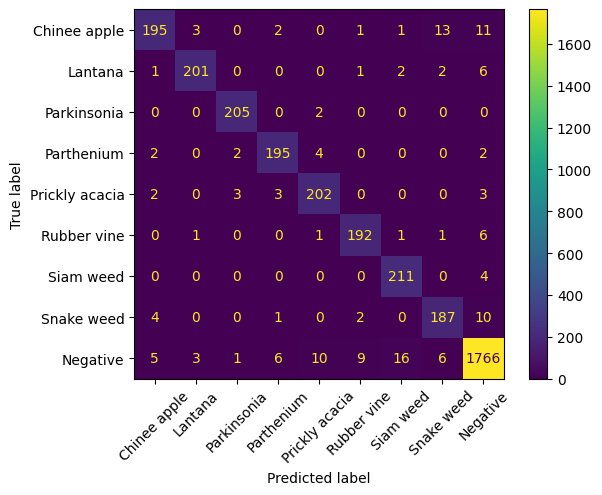

In [29]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)
print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)
print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.90090   0.88496   0.89286       226
       Lantana    0.92237   0.94836   0.93519       213
   Parkinsonia    0.97156   0.99034   0.98086       207
    Parthenium    0.94175   0.94634   0.94404       205
Prickly acacia    0.88696   0.95775   0.92099       213
   Rubber vine    0.93659   0.95050   0.94349       202
     Siam weed    0.90948   0.98140   0.94407       215
    Snake weed    0.89474   0.91667   0.90557       204
      Negative    0.98308   0.95664   0.96968      1822

      accuracy                        0.95181      3507
     macro avg    0.92749   0.94810   0.93742      3507
  weighted avg    0.95283   0.95181   0.95203      3507


                False Positive Rate  Accuracy
Chinee apple               0.006705  0.884956
Lantana                    0.005161  0.948357
Parkinsonia                0.001818  0.990338
Parthenium                 0.003634  0.946341
Prickly acacia    

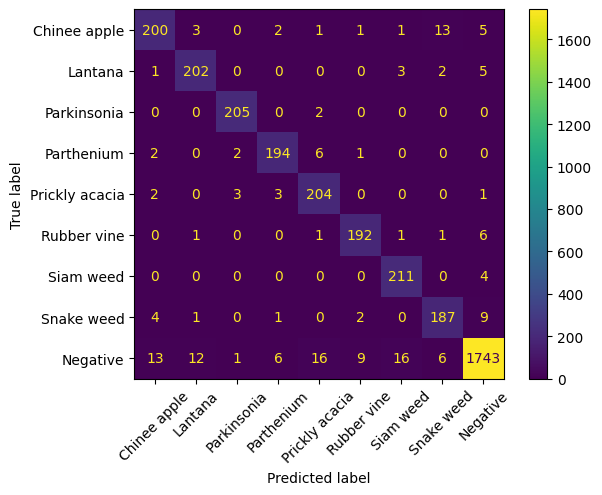

In [30]:
printStats(a,b,0.11)

## Clear Files

In [31]:
shutil.rmtree(base_dir)

In [32]:
model = buildModel(IMG_SIZE, mtype=MODEL_TYPE, cbam_order=CBAM_ORDER, skip_preprocess=True)
model.load_weights(MODEL_NAME, skip_mismatch=True)#(model_weights, by_name=True, skip_mismatch=True)
model.trainable= False
model.save(model.name+".keras")
model.summary()

Base Model: MobilenetV3small_base_
228
Model: "DeepWeeds-MobilenetV3small_base_"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 MobilenetV3small_base_ (Fu  (None, 7, 7, 576)            939120    ['input[0][0]']               
 nctional)                                                                                        
                                                                                                  
 dropout_5 (Dropout)         (None, 7, 7, 576)            0         ['MobilenetV3small_base_[0][0]
                                                                    ']                            
                            